## Birth Rate Prediction Project

The goal of this project is to see what variables have the large impact on birth rate and use these variables to predict birth rates in countries.

This dataset was exported from The World Bank.

In [1]:
# import libraries
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
# import ML models

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree

### Import data

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/tylered/birth-rate-prediction/main/World_Data.csv')

### Preview data

In [4]:
df

,Country Name,Country Code,Series Name,Series Code,2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022]
0,Afghanistan,AFG,Adjusted net national income (annual % growth),NY.ADJ.NNTY.KD.ZG,..,..,..,..,..
1,Afghanistan,AFG,Adjusted net national income per capita (annua...,NY.ADJ.NNTY.PC.KD.ZG,..,..,..,..,..
2,Afghanistan,AFG,Adjusted net national income (current US$),NY.ADJ.NNTY.CD,16815188084.6708,17645416937.3793,18515111650.4997,..,..
3,Afghanistan,AFG,Adjusted net national income per capita (curre...,NY.ADJ.NNTY.PC.CD,458.344565843406,467.186947260786,475.084737273174,..,..
4,Afghanistan,AFG,Adjusted savings: education expenditure (% of ...,NY.ADJ.AEDU.GN.ZS,2.59444730379137,2.59444730379137,2.59444730379137,..,..
...,...,...,...,...,...,...,...,...,...
9331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9334,Data from database: World Development Indicators,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data clean

In [5]:
df['Series Name'] = df['Series Name'].dropna()

In [6]:
df.dropna(subset=['Series Name'], inplace=True)

In [7]:
df.drop(columns=['Country Code', 'Series Code'], inplace=True)

In [8]:
df = df.melt(id_vars=['Country Name', 'Series Name'], var_name='Year', ignore_index=False)

In [9]:
df

,Country Name,Series Name,Year,value
0,Afghanistan,Adjusted net national income (annual % growth),2018 [YR2018],..
1,Afghanistan,Adjusted net national income per capita (annua...,2018 [YR2018],..
2,Afghanistan,Adjusted net national income (current US$),2018 [YR2018],16815188084.6708
3,Afghanistan,Adjusted net national income per capita (curre...,2018 [YR2018],458.344565843406
4,Afghanistan,Adjusted savings: education expenditure (% of ...,2018 [YR2018],2.59444730379137
...,...,...,...,...
9326,Zimbabwe,Number of maternal deaths,2022 [YR2022],..
9327,Zimbabwe,Number of infant deaths,2022 [YR2022],..
9328,Zimbabwe,Forest area (sq. km),2022 [YR2022],..
9329,Zimbabwe,Chemicals (% of value added in manufacturing),2022 [YR2022],..


In [10]:
df = df.pivot(index=['Year', 'Country Name'],  columns='Series Name', values='value')

In [11]:
df.reset_index(inplace=True)

In [12]:
# remove brackets from year, e.g. '2022 [YR2022]' to '2022'
df.Year = df.Year.apply(lambda x: x[0:4])

In [13]:
# to_float() function converts an object to float data type
def to_float(obj):
    try: 
        num = float(obj)
        return num
    except:
        return np.NAN

In [14]:
# convert string to float
for i in range(2, len(df.columns)):
    df.iloc[:, i] = df.iloc[:, i].apply(lambda x: to_float(x))

/var/folders/_w/c37_2z5d7tzglvldbyrskvd00000gn/T/ipykernel_5633/429227795.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, i] = df.iloc[:, i].apply(lambda x: to_float(x))


In [15]:
df

Series Name,Year,Country Name,Adjusted net national income (annual % growth),Adjusted net national income (current US$),Adjusted net national income per capita (annual % growth),Adjusted net national income per capita (current US$),Adjusted savings: consumption of fixed capital (current US$),Adjusted savings: education expenditure (% of GNI),Adjusted savings: education expenditure (current US$),Adjusted savings: gross savings (% of GNI),...,Methane emissions (kt of CO2 equivalent),Number of infant deaths,Number of maternal deaths,Oil rents (% of GDP),"Physicians (per 1,000 people)",Tax revenue (% of GDP),Time required to build a warehouse (days),Total tax and contribution rate (% of profit),Unemployment with advanced education (% of total labor force with advanced education),Unemployment with basic education (% of total labor force with basic education)
0,2018,Afghanistan,NaN,1.681519e+10,NaN,458.344566,1.353066e+09,2.594447,4.732489e+08,NaN,...,15919.024550,63723.0,9000.0,0.018854,0.2966,NaN,199.0,71.4,NaN,NaN
1,2018,Albania,3.708238,1.237962e+10,3.964435,4318.911492,2.578132e+09,3.303909,5.001455e+08,16.607106,...,3008.433359,256.0,2.0,1.469834,NaN,18.545967,324.0,37.3,15.09,6.36
2,2018,Algeria,1.377296,1.368789e+11,-0.533998,3264.694290,1.460666e+10,4.467196,7.638904e+09,41.244391,...,91576.874980,20797.0,800.0,15.942808,1.7193,NaN,131.0,66.1,NaN,NaN
3,2018,American Samoa,NaN,NaN,NaN,NaN,NaN,11.760709,NaN,NaN,...,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,2018,Andorra,NaN,NaN,NaN,NaN,2.850726e+08,2.440000,NaN,NaN,...,52.830455,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,2022,Virgin Islands (U.S.),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1081,2022,West Bank and Gaza,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.56,21.60
1082,2022,"Yemen, Rep.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1083,2022,Zambia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df.to_csv('how.csv')

In [17]:
df

Series Name,Year,Country Name,Adjusted net national income (annual % growth),Adjusted net national income (current US$),Adjusted net national income per capita (annual % growth),Adjusted net national income per capita (current US$),Adjusted savings: consumption of fixed capital (current US$),Adjusted savings: education expenditure (% of GNI),Adjusted savings: education expenditure (current US$),Adjusted savings: gross savings (% of GNI),...,Methane emissions (kt of CO2 equivalent),Number of infant deaths,Number of maternal deaths,Oil rents (% of GDP),"Physicians (per 1,000 people)",Tax revenue (% of GDP),Time required to build a warehouse (days),Total tax and contribution rate (% of profit),Unemployment with advanced education (% of total labor force with advanced education),Unemployment with basic education (% of total labor force with basic education)
0,2018,Afghanistan,NaN,1.681519e+10,NaN,458.344566,1.353066e+09,2.594447,4.732489e+08,NaN,...,15919.024550,63723.0,9000.0,0.018854,0.2966,NaN,199.0,71.4,NaN,NaN
1,2018,Albania,3.708238,1.237962e+10,3.964435,4318.911492,2.578132e+09,3.303909,5.001455e+08,16.607106,...,3008.433359,256.0,2.0,1.469834,NaN,18.545967,324.0,37.3,15.09,6.36
2,2018,Algeria,1.377296,1.368789e+11,-0.533998,3264.694290,1.460666e+10,4.467196,7.638904e+09,41.244391,...,91576.874980,20797.0,800.0,15.942808,1.7193,NaN,131.0,66.1,NaN,NaN
3,2018,American Samoa,NaN,NaN,NaN,NaN,NaN,11.760709,NaN,NaN,...,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,2018,Andorra,NaN,NaN,NaN,NaN,2.850726e+08,2.440000,NaN,NaN,...,52.830455,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,2022,Virgin Islands (U.S.),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1081,2022,West Bank and Gaza,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.56,21.60
1082,2022,"Yemen, Rep.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1083,2022,Zambia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df.columns

Index(['Year', 'Country Name',
       'Adjusted net national income (annual % growth)',
       'Adjusted net national income (current US$)',
       'Adjusted net national income per capita (annual % growth)',
       'Adjusted net national income per capita (current US$)',
       'Adjusted savings: consumption of fixed capital (current US$)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Adjusted savings: education expenditure (current US$)',
       'Adjusted savings: gross savings (% of GNI)',
       'Agricultural land (% of land area)', 'Agricultural land (sq. km)',
       'Air transport, passengers carried',
       'Armed forces personnel (% of total labor force)',
       'Armed forces personnel, total',
       'Battle-related deaths (number of people)',
       'CO2 emissions (metric tons per capita)',
       'Chemicals (% of value added in manufacturing)',
       'Death rate, crude (per 1,000 people)',
       'Fertility rate, total (births per woman)', 'Forest

In [19]:
lst = ['Year', 'Country Name', 'Death rate, crude (per 1,000 people)',
       'Fertility rate, total (births per woman)', 'Forest area (sq. km)', 'GDP (current US$)', 'GDP growth (annual %)',
       'GDP per capita (current US$)', 'GNI (current US$)',
       'GNI growth (annual %)', 'Gini index', 'Individuals using the Internet (% of population)',  'Land area (sq. km)', 'Unemployment with basic education (% of total labor force with basic education)', 'Unemployment with advanced education (% of total labor force with advanced education)']

In [20]:
lst

['Year',
 'Country Name',
 'Death rate, crude (per 1,000 people)',
 'Fertility rate, total (births per woman)',
 'Forest area (sq. km)',
 'GDP (current US$)',
 'GDP growth (annual %)',
 'GDP per capita (current US$)',
 'GNI (current US$)',
 'GNI growth (annual %)',
 'Gini index',
 'Individuals using the Internet (% of population)',
 'Land area (sq. km)',
 'Unemployment with basic education (% of total labor force with basic education)',
 'Unemployment with advanced education (% of total labor force with advanced education)']

In [21]:
df = df[lst]

In [22]:
df

Series Name,Year,Country Name,"Death rate, crude (per 1,000 people)","Fertility rate, total (births per woman)",Forest area (sq. km),GDP (current US$),GDP growth (annual %),GDP per capita (current US$),GNI (current US$),GNI growth (annual %),Gini index,Individuals using the Internet (% of population),Land area (sq. km),Unemployment with basic education (% of total labor force with basic education),Unemployment with advanced education (% of total labor force with advanced education)
0,2018,Afghanistan,6.981,5.002,12084.4,1.841886e+10,1.189228,502.057099,1.861027e+10,NaN,NaN,16.800000,652230.0,NaN,NaN
1,2018,Albania,8.308,1.440,7889.0,1.515642e+10,4.019346,5287.660817,1.513798e+10,3.653875,30.1,65.400000,27400.0,6.36,15.09
2,2018,Algeria,4.482,3.023,19300.0,1.749109e+11,1.200000,4171.795309,1.705071e+11,0.211466,NaN,49.038468,2381741.0,NaN,NaN
3,2018,American Samoa,NaN,NaN,171.9,6.390000e+08,2.671119,13195.935900,NaN,NaN,NaN,NaN,200.0,NaN,NaN
4,2018,Andorra,4.400,NaN,160.0,3.218420e+09,1.588765,42904.828456,NaN,NaN,NaN,NaN,470.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,2022,Virgin Islands (U.S.),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1081,2022,West Bank and Gaza,NaN,NaN,NaN,1.911190e+10,3.932977,3789.327966,2.311510e+10,4.838522,NaN,NaN,NaN,21.60,29.56
1082,2022,"Yemen, Rep.",NaN,NaN,NaN,NaN,NaN,676.928385,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1083,2022,Zambia,NaN,NaN,NaN,2.978445e+10,4.744942,1487.907764,2.813440e+10,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
df.dtypes

Series Name
Year                                                                                      object
Country Name                                                                              object
Death rate, crude (per 1,000 people)                                                     float64
Fertility rate, total (births per woman)                                                 float64
Forest area (sq. km)                                                                     float64
GDP (current US$)                                                                        float64
GDP growth (annual %)                                                                    float64
GDP per capita (current US$)                                                             float64
GNI (current US$)                                                                        float64
GNI growth (annual %)                                                                    float64
Gini index        

In [24]:
df.corr()

/var/folders/_w/c37_2z5d7tzglvldbyrskvd00000gn/T/ipykernel_5633/1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


Series Name,"Death rate, crude (per 1,000 people)","Fertility rate, total (births per woman)",Forest area (sq. km),GDP (current US$),GDP growth (annual %),GDP per capita (current US$),GNI (current US$),GNI growth (annual %),Gini index,Individuals using the Internet (% of population),Land area (sq. km),Unemployment with basic education (% of total labor force with basic education),Unemployment with advanced education (% of total labor force with advanced education)
Series Name,,,,,,,,,,,,,
"Death rate, crude (per 1,000 people)",1.000000,-0.103048,0.098391,0.057039,0.036070,-0.034236,0.055509,0.040325,-0.405127,0.050274,0.059116,0.262170,-0.216125
"Fertility rate, total (births per woman)",-0.103048,1.000000,-0.071648,-0.153580,0.090540,-0.456742,-0.156744,0.068071,0.238926,-0.809462,-0.034176,-0.157102,0.371019
Forest area (sq. km),0.098391,-0.071648,1.000000,0.408116,0.022765,-0.000292,0.402749,0.005216,0.252670,0.078313,0.923513,0.048899,-0.059212
GDP (current US$),0.057039,-0.153580,0.408116,1.000000,0.018428,0.147079,0.999880,0.020968,0.087085,0.144878,0.544979,-0.051213,-0.116549
GDP growth (annual %),0.036070,0.090540,0.022765,0.018428,1.000000,0.001307,0.013850,0.838974,0.026460,-0.101136,0.032858,-0.095362,-0.030251
GDP per capita (current US$),-0.034236,-0.456742,-0.000292,0.147079,0.001307,1.000000,0.183993,-0.037118,-0.340043,0.549101,-0.005297,-0.004808,-0.405770
GNI (current US$),0.055509,-0.156744,0.402749,0.999880,0.013850,0.183993,1.000000,0.020145,0.086073,0.147205,0.538823,-0.050360,-0.116218
GNI growth (annual %),0.040325,0.068071,0.005216,0.020968,0.838974,-0.037118,0.020145,1.000000,-0.036350,-0.098491,0.021995,-0.041024,0.033249
Gini index,-0.405127,0.238926,0.252670,0.087085,0.026460,-0.340043,0.086073,-0.036350,1.000000,-0.317714,0.236185,-0.153068,0.269581


/var/folders/_w/c37_2z5d7tzglvldbyrskvd00000gn/T/ipykernel_5633/58359773.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


<Axes: xlabel='Series Name', ylabel='Series Name'>

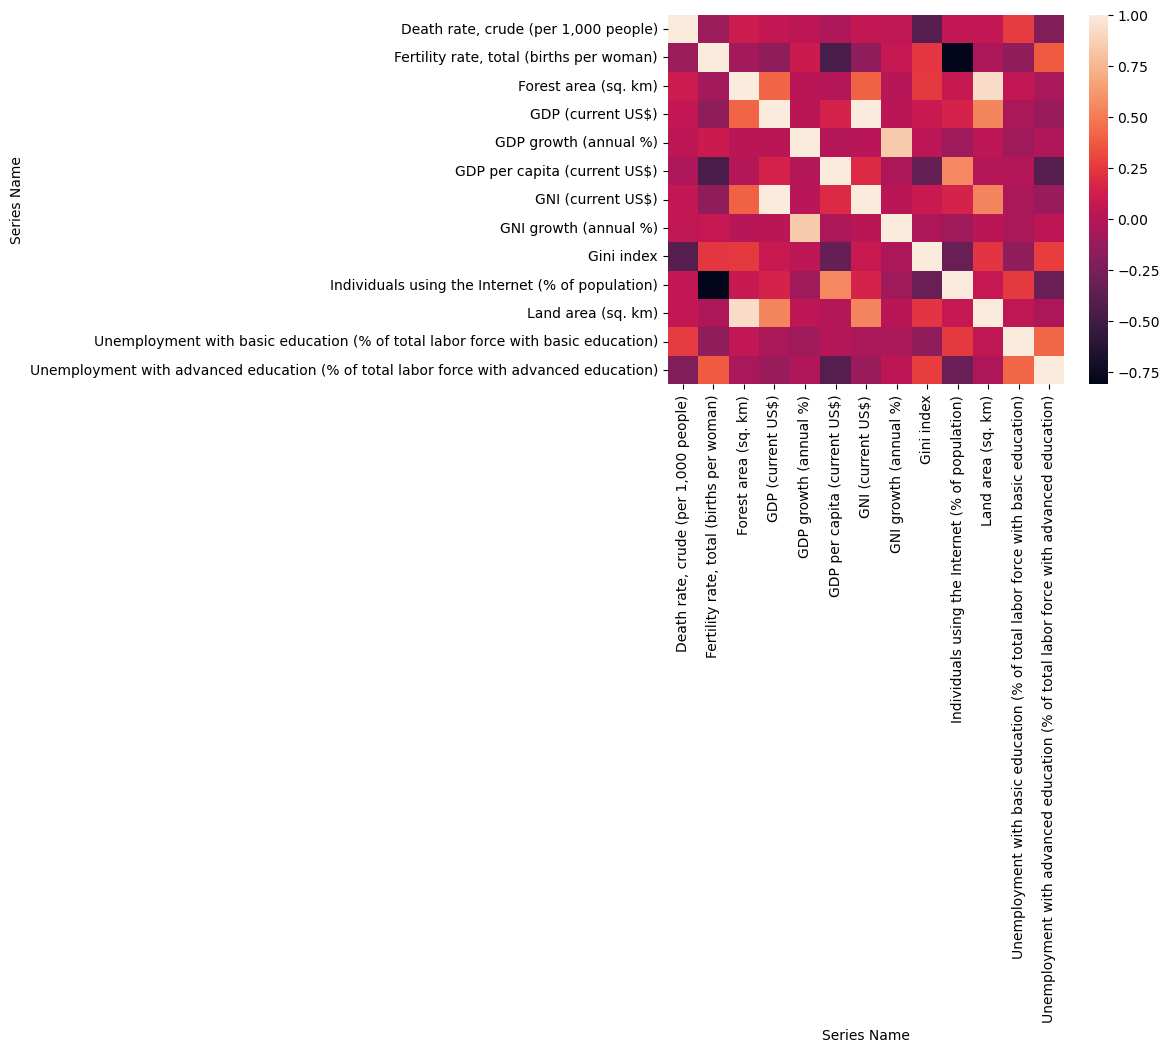

In [25]:
sns.heatmap(df.corr())

### Test train split

In [26]:
df[(df['Year'] == '2019') | (df['Year'] == '2018')]

Series Name,Year,Country Name,"Death rate, crude (per 1,000 people)","Fertility rate, total (births per woman)",Forest area (sq. km),GDP (current US$),GDP growth (annual %),GDP per capita (current US$),GNI (current US$),GNI growth (annual %),Gini index,Individuals using the Internet (% of population),Land area (sq. km),Unemployment with basic education (% of total labor force with basic education),Unemployment with advanced education (% of total labor force with advanced education)
0,2018,Afghanistan,6.981,5.002,12084.4,1.841886e+10,1.189228,502.057099,1.861027e+10,NaN,NaN,16.800000,652230.0,NaN,NaN
1,2018,Albania,8.308,1.440,7889.0,1.515642e+10,4.019346,5287.660817,1.513798e+10,3.653875,30.1,65.400000,27400.0,6.36,15.09
2,2018,Algeria,4.482,3.023,19300.0,1.749109e+11,1.200000,4171.795309,1.705071e+11,0.211466,NaN,49.038468,2381741.0,NaN,NaN
3,2018,American Samoa,NaN,NaN,171.9,6.390000e+08,2.671119,13195.935900,NaN,NaN,NaN,NaN,200.0,NaN,NaN
4,2018,Andorra,4.400,NaN,160.0,3.218420e+09,1.588765,42904.828456,NaN,NaN,NaN,NaN,470.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,2019,Virgin Islands (U.S.),8.200,2.050,197.6,4.117000e+09,2.777778,38596.030712,NaN,NaN,NaN,NaN,350.0,NaN,NaN
430,2019,West Bank and Gaza,3.225,3.642,101.4,1.713350e+10,1.362687,3656.858271,2.016470e+10,2.075230,NaN,70.622584,6020.0,22.51,30.46
431,2019,"Yemen, Rep.",6.416,3.963,5490.0,NaN,NaN,693.816484,NaN,NaN,NaN,NaN,527970.0,NaN,NaN
432,2019,Zambia,6.571,4.451,450022.4,2.330867e+10,1.441306,1268.120941,2.290408e+10,NaN,NaN,16.800000,743390.0,4.79,8.32


In [27]:
df_droppedna = df.dropna()

/var/folders/_w/c37_2z5d7tzglvldbyrskvd00000gn/T/ipykernel_5633/3953856339.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_droppedna.corr())


<Axes: xlabel='Series Name', ylabel='Series Name'>

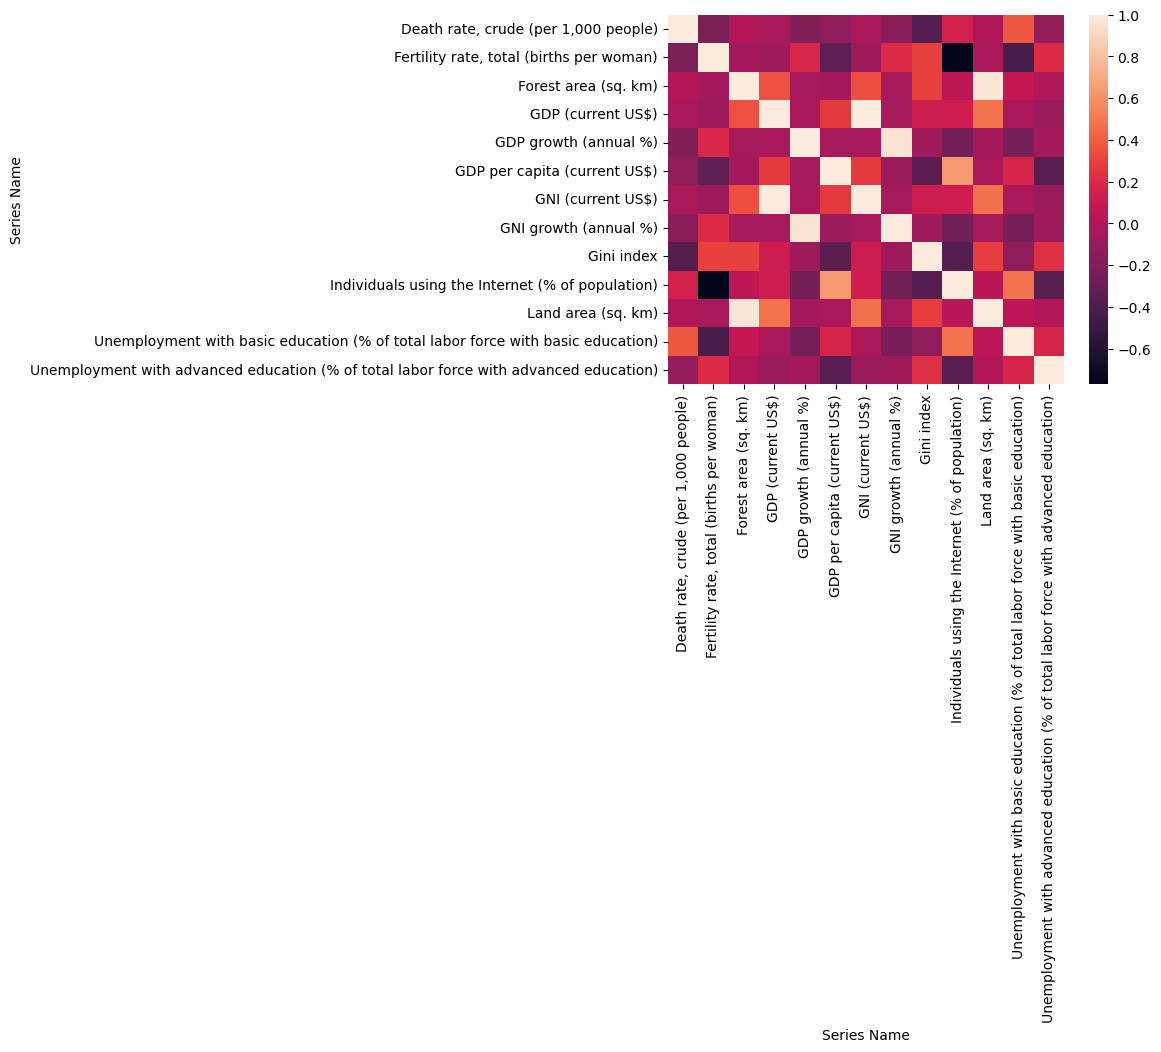

In [28]:
sns.heatmap(df_droppedna.corr())

In [29]:
df_droppedna.iloc[:, 2:]

Series Name,"Death rate, crude (per 1,000 people)","Fertility rate, total (births per woman)",Forest area (sq. km),GDP (current US$),GDP growth (annual %),GDP per capita (current US$),GNI (current US$),GNI growth (annual %),Gini index,Individuals using the Internet (% of population),Land area (sq. km),Unemployment with basic education (% of total labor force with basic education),Unemployment with advanced education (% of total labor force with advanced education)
1,8.308,1.4400,7889.0,1.515642e+10,4.019346,5287.660817,1.513798e+10,3.653875,30.1,65.400000,27400.000,6.36,15.09
7,7.680,2.0390,287910.0,5.248199e+11,-2.617396,11795.162885,5.060941e+11,-3.687890,41.3,77.700000,2736690.000,11.08,3.64
8,9.750,1.5720,3288.9,1.245794e+10,5.200000,4391.923274,1.265828e+10,3.372669,34.4,68.245052,28470.000,11.74,13.08
11,9.500,1.4700,38919.7,4.549912e+11,2.425385,51466.556563,4.505357e+11,2.384213,30.8,87.479137,82520.000,11.45,3.30
17,12.700,1.4480,87386.0,6.003116e+10,3.149639,6360.052060,5.788600e+10,3.291158,25.2,79.129887,202980.000,10.52,2.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...
613,10.400,1.1900,185721.7,1.276963e+12,-11.325438,26959.675437,1.280088e+12,-11.264154,34.9,93.205649,499556.645,21.31,10.23
621,9.500,1.6700,279800.0,5.470542e+11,-2.170213,52837.903978,5.669764e+11,-1.579217,28.9,94.539431,407283.532,24.61,4.73
637,15.900,1.2170,96900.0,1.566177e+11,-3.752804,3751.737305,1.600400e+11,-2.703275,25.6,75.037909,579400.000,11.82,7.99
640,10.300,1.6415,3097950.0,2.106047e+13,-2.767803,63528.634303,2.147236e+13,-3.119944,39.7,90.620470,9147420.000,11.72,5.59


In [30]:
df_droppedna.drop(columns='Fertility rate, total (births per woman)')

Series Name,Year,Country Name,"Death rate, crude (per 1,000 people)",Forest area (sq. km),GDP (current US$),GDP growth (annual %),GDP per capita (current US$),GNI (current US$),GNI growth (annual %),Gini index,Individuals using the Internet (% of population),Land area (sq. km),Unemployment with basic education (% of total labor force with basic education),Unemployment with advanced education (% of total labor force with advanced education)
1,2018,Albania,8.308,7889.0,1.515642e+10,4.019346,5287.660817,1.513798e+10,3.653875,30.1,65.400000,27400.000,6.36,15.09
7,2018,Argentina,7.680,287910.0,5.248199e+11,-2.617396,11795.162885,5.060941e+11,-3.687890,41.3,77.700000,2736690.000,11.08,3.64
8,2018,Armenia,9.750,3288.9,1.245794e+10,5.200000,4391.923274,1.265828e+10,3.372669,34.4,68.245052,28470.000,11.74,13.08
11,2018,Austria,9.500,38919.7,4.549912e+11,2.425385,51466.556563,4.505357e+11,2.384213,30.8,87.479137,82520.000,11.45,3.30
17,2018,Belarus,12.700,87386.0,6.003116e+10,3.149639,6360.052060,5.788600e+10,3.291158,25.2,79.129887,202980.000,10.52,2.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613,2020,Spain,10.400,185721.7,1.276963e+12,-11.325438,26959.675437,1.280088e+12,-11.264154,34.9,93.205649,499556.645,21.31,10.23
621,2020,Sweden,9.500,279800.0,5.470542e+11,-2.170213,52837.903978,5.669764e+11,-1.579217,28.9,94.539431,407283.532,24.61,4.73
637,2020,Ukraine,15.900,96900.0,1.566177e+11,-3.752804,3751.737305,1.600400e+11,-2.703275,25.6,75.037909,579400.000,11.82,7.99
640,2020,United States,10.300,3097950.0,2.106047e+13,-2.767803,63528.634303,2.147236e+13,-3.119944,39.7,90.620470,9147420.000,11.72,5.59


### Splitting data for modeling

In [31]:
train = df_droppedna[(df_droppedna['Year'] == '2019') | (df_droppedna['Year'] == '2018')]

In [32]:
test = df_droppedna[df_droppedna['Year'] == '2020']

In [33]:
train_y = train['Fertility rate, total (births per woman)']
train_x = train.iloc[:, 2:].drop(columns='Fertility rate, total (births per woman)')

test_y = test['Fertility rate, total (births per woman)']
test_x = test.iloc[:, 2:].drop(columns='Fertility rate, total (births per woman)')

In [34]:
data_prep = df_droppedna.drop(columns='Year')

In [35]:
target = data_prep['Fertility rate, total (births per woman)']
feats = data_prep.iloc[:, 2:].drop(columns='Fertility rate, total (births per woman)')

In [36]:
feats.shape

(166, 11)

In [37]:
new_train_x, new_test_x, new_train_y, new_test_y = train_test_split(feats, target, test_size=0.2, random_state=5)

### Modeling

### First model

In [38]:
degrees_1 = [i for i in range(1, 8)]

In [39]:
pipe_1 = Pipeline([('scaler', StandardScaler()), ('pf', PolynomialFeatures(include_bias=False)), ('rr', Ridge())])
model_1 = GridSearchCV(estimator=pipe_1, param_grid={'pf__degree': [1, 2, 3, 4, 5], 'rr__alpha': [0.1, 0.25, 0.5, 0.75, 1, 2, 3, 4, 5, 10, 20]})

model_1.fit(new_train_x, new_train_y)

print(f"Ridge regression with a degree of {model_1.best_estimator_['pf'].degree} best performance has an R2 of {model_1.score(new_test_x, new_test_y)} at alpha value={model_1.best_estimator_['rr'].alpha}.")

Ridge regression with a degree of 2 best performance has an R2 of 0.7874610492659373 at alpha value=20.


### Second model

In [40]:
pipe_2 = Pipeline([('scaler', StandardScaler()), ('pca', PCA()), ('rr', Ridge())])
model_2 = GridSearchCV(estimator=pipe_2, param_grid={'pca__n_components':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 'rr__alpha': [0.1, 0.25, 0.5, 0.75, 1, 2, 3, 4, 9, 10, 20]})

model_2.fit(new_train_x, new_train_y)
print(model_2.best_estimator_)
print(f"Ridge regression best score is {model_2.score(new_test_x, new_test_y)} at {model_2.best_estimator_['pca'].n_components} components and alpha value={model_2.best_estimator_['rr'].alpha}.")


Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=11)),
                ('rr', Ridge(alpha=20))])
Ridge regression best score is 0.5188678071015279 at 11 components and alpha value=20.


### Third model

In [41]:
model_3 = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=11)), ('lr', LinearRegression())])

In [42]:
model_3.fit(new_train_x, new_train_y)
model_3.score(new_test_x, new_test_y)

0.6089310877602375

### Fourth model

In [43]:
model_4 = Pipeline([('scaler', StandardScaler()), ('pf', PolynomialFeatures(degree=1, include_bias=False)), ('lr', LinearRegression())])


In [44]:
model_4.fit(new_train_x, new_train_y)
model_4.score(new_test_x, new_test_y)

0.6089310877602367

### Scoring models

In [45]:
for i in range(10):
    new_train_x, new_test_x, new_train_y, new_test_y = train_test_split(feats, target, test_size=0.2, random_state=i)
    
    print('Random state value:', i)
    model_1.fit(new_train_x, new_train_y)
    print('Model 1', model_1.score(new_test_x, new_test_y))
    
    model_2.fit(new_train_x, new_train_y)
    print('Model 2', model_2.score(new_test_x, new_test_y))
    
    model_3.fit(new_train_x, new_train_y)
    print('Model 3', model_3.score(new_test_x, new_test_y))
    
    model_4.fit(new_train_x, new_train_y)
    print('Model 4', model_4.score(new_test_x, new_test_y))
    
    print()
    

Random state value: 0
Model 1 0.6533740817979028
Model 2 0.638586938946731
Model 3 0.5906961912588029
Model 4 0.5906961912588058

Random state value: 1
Model 1 0.031633635232104385
Model 2 -0.07651091759023076
Model 3 -0.27952986664467305
Model 4 -0.27952986664468105

Random state value: 2
Model 1 0.7326714258982392
Model 2 0.5393474356986393
Model 3 0.5848201907225813
Model 4 0.5848201907225814

Random state value: 3
Model 1 0.8208377392376183
Model 2 0.6273364111343811
Model 3 0.6659826252318349
Model 4 0.6659826252318355

Random state value: 4
Model 1 0.7742608024598939
Model 2 0.6712951814697538
Model 3 0.6873021198345345
Model 4 0.6873021198345344

Random state value: 5
Model 1 0.7874610492659373
Model 2 0.5188678071015279
Model 3 0.6089310877602375
Model 4 0.6089310877602367

Random state value: 6
Model 1 0.6142372943894161
Model 2 0.41906040347221085
Model 3 0.6122950393734028
Model 4 0.6122950393733964

Random state value: 7
Model 1 0.4242668524222609
Model 2 0.2772161824977209

Model 1 has the best R2 values for 8 of 10 tests.